# Trabajo Práctico 2: Reseñas de Películas - Ensamble

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

En este caso decidimos trabajar con el dataset que tenía preprocesamiento más complejo. Este dataset incluye técnicas de preprocesamiento como lematización, filtro de stop words, análisis de part-of-speech utilizando la función del lenguaje de cada token como sufijo, manejo de negaciones agregando el prefijo "NO_" y reconocimiento de entidades. Además cuenta con información sobre la cantidad de negaciones, adjetivos negados y exclamaciones en cada crítica.

In [3]:
df = pd.read_csv('../datasets/train-complejo.csv', index_col=0)
df.head()

,texto_preprocesado,num_neg,num_adj_neg,num_exclm,lang,sentimiento
ID,,,,,,
0,critico_NOUN mencionar_VERB oz_DET episodio_NO...,7,4,0,es,positivo
1,pequén_ADJ pequén_ADJ produccion_PROPN tecnica...,2,0,2,es,positivo
2,pense_VERB maravilloso_ADJ pasar_VERB tiempo_N...,2,0,1,es,positivo
3,basicamente_ADV familia_NOUN nino_NOUN pequeno...,0,0,4,es,negativo
4,amor_NOUN tiempo_NOUN pelicula_NOUN visualment...,1,2,0,es,positivo


Al igual que como se hizo con algunos de otros modelos, nos aseguramos de hacer la stratificación no solamente en base al sentimiento sino que también en base al idioma, para que el modelo aprenda a manejar casos en los que se encuentren críticas no solo en español.

In [4]:
from sklearn.model_selection import train_test_split

df['lang+sentimiento'] = df['lang'].astype(str) + df['sentimiento'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(df['texto_preprocesado'],
                                                    df[['lang+sentimiento', 'sentimiento']],
                                                    stratify=df['lang+sentimiento'],
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train['sentimiento'],
                                                      stratify=y_train['lang+sentimiento'],
                                                     test_size=0.2,
                                                     random_state=42)

In [5]:
X_train.head()

ID
11688    consejero_NOUN cabeza_NOUN forma_NOUN peak_NOU...
41644    simplemente_ADV pelicula_NOUN deber_AUX peor_A...
22573    acabar_VERB comprar_VERB dvd_NOUN deber_AUX te...
48102    NO_calificadoel_VERB NO_nivel_NOUN NO_escritur...
32220    coger_VERB siquiera_NOUN gracioso_ADJ infeccio...
Name: texto_preprocesado, dtype: object

In [6]:
y_test = y_test['sentimiento']

Optamos por usar un vectorizador bastante similar al que utilizamos en los demás modelos tradicionales, utilizando la técnica TF-IDF con ngramas de rango 1 a 2. Probamos con mayores rangos de ngramas también para ver si la combinación de diferentes modelos prevenía el overfitting que un mayor vocabulario introducía, sin embargo los mejores resultados siguieron siendo arrojados por los vectorizadores de menor dimensión.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=20, max_df=0.8)
encoder = LabelEncoder()

X_train_trans = vectorizer.fit_transform(X_train)
X_valid_trans = vectorizer.transform(X_valid)
X_test_trans = vectorizer.transform(X_test)

y_train_trans = encoder.fit_transform(y_train)
y_valid_trans = encoder.transform(y_valid)
y_test_trans = encoder.transform(y_test)

In [8]:
y_train_trans

array([1, 0, 1, ..., 1, 0, 1])

## Armado de Ensamble

Decidimos juntar los mejores modelos de los que ya habíamos entrenado en el ensamble. Si bien probamos con otras alternativos, como introducir modelos diferentes como SVM y KNN, enfrentamos problema a la hora de configurar los hiperparámetros de estos modelos individualmente, debido a los altos tiempos de entrenamiento de ambos en comparación con los que ya habíamos trabajado.

Cada destacar que, a diferencia del XGBoost que entrenamos de manera individual, para este XGBoost utilizamos el dataset que se utilizó para todo el ensamble, la versión más compleja, mientras que en el anterior XGBoost se utilizó la versión más simple, que dió mejores resultados. Aún así, elegimos este dataset con este preprocesamiento para el ensamble para que las bondades de los estimadores individuales entre si contrarestaran el overfitting.

In [9]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.3,
    reg_alpha=0.4,
    reg_lambda=0.3,
    gamma=6,
    max_depth=2,
)

In [ ]:
xgb.fit(X_train_trans, y_train_trans, eval_set=[(X_valid_trans, y_valid_trans)])

Utilizamos los hiperparámetros que ya se había probado con XGBoost utilizando este dataset más complejo. En general, se asemejan mucho a los resultados que logramos con la mejor versión de este estimador que utiliza el dataset más sencillo.

In [11]:
from sklearn.metrics import classification_report

y_train_pred = xgb.predict(X_train_trans)

print(classification_report(y_train_pred, y_train_trans))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     15361
           1       0.92      0.88      0.90     16638

    accuracy                           0.90     31999
   macro avg       0.90      0.90      0.90     31999
weighted avg       0.90      0.90      0.90     31999



In [12]:
y_valid_pred = xgb.predict(X_valid_trans)

print(classification_report(y_valid_pred, y_valid_trans))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      3795
           1       0.87      0.83      0.85      4205

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000



In [13]:
y_test_pred = xgb.predict(X_test_trans)

print(classification_report(y_test_pred, y_test_trans))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      4772
           1       0.87      0.83      0.85      5228

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Además agregar un Random Forest y un Naive Bayes.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=1000,
    criterion='gini',
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=8,
    oob_score=True,
    n_jobs=-1,
)

In [15]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

Probamos con dos tipos de ensambles diferentes: Voting y Stacking. El segundo de estos tipos de ensamble arrojó resultados significativamente mejores que el primero, incluso cuando se utilizaban los mismos modelos para armarlos. Con el voting classifier también se probó configurando los pesos de los estimadores, sin embargo su rendimiento era mucho peor que el de los estimadores por separado incluso.

In [16]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('xgboost', xgb),
    ('random-forest', rf),
    ('naive-bayes', nb),
]

clf = StackingClassifier(
    estimators=estimators,
    cv=5,
    stack_method='auto',
    n_jobs=-1,
)

# Entrenamiento

In [17]:
clf.fit(X_train_trans, y_train_trans)

StackingClassifier(cv=5,
                   estimators=[('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=6,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lea...
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=500, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('random-forest',
                                RandomForestClassifier(max_depth=15,
                                                       min_samples_leaf=8,
                                                       min_samples_split=10,
                                                       n_estimators=1000,
                                                       n_jobs=-1,
                                                       oob_score=True)),
                               ('naive-bayes', MultinomialNB())],
                   n_jobs=-1)

Finalmente evaluamos los resultados del ensamble en los tres conjuntos de datos utilizados.

In [18]:
y_train_pred = clf.predict(X_train_trans)

print(classification_report(y_train_pred, y_train_trans))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     15759
           1       0.92      0.90      0.91     16240

    accuracy                           0.91     31999
   macro avg       0.91      0.91      0.91     31999
weighted avg       0.91      0.91      0.91     31999



In [19]:
y_valid_pred = clf.predict(X_valid_trans)

print(classification_report(y_valid_pred, y_valid_trans))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3899
           1       0.88      0.86      0.87      4101

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



In [24]:
y_test_pred = clf.predict(X_test_trans)

print(classification_report(y_test_pred, y_test_trans))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4911
           1       0.88      0.86      0.87      5089

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Este último ensamble introdujo una mejora significativa comparado a los resultados anteriores, sin embargo sigue siendo equiparable con los resultados de los estimadores individuales, superándolos por muy poco solamente.

Finalmente obtenemos nuestra métrica adicional de elección, accuracy:

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_pred, y_test_trans)

0.8699

Si visualizamos la matriz de confusión notamos que esta todavía más balanceado con los modelos anteriores, pero las diferencias son ligeras. Sigue habiendo una buena tendencia a clasificar verdaderos positivos y negativos.

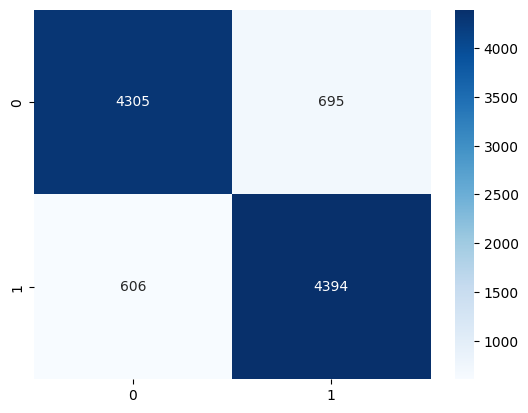

In [31]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test_trans, y_test_pred), cmap='Blues', annot=True, fmt='g')
plt.show()

# Predicciones

Finalmente armamos las predicciones para la competencia de Kaggle. En este caso decidimos probar primero reentrenando el ensamble con la totalidad del dataset de entrenamiento, ya que vimos que no sufría tanto overfitting.

In [33]:
X_full_trans = vectorizer.fit_transform(df['texto_preprocesado'])
y_full_trans = encoder.fit_transform(df['sentimiento'])

In [34]:
clf.fit(X_full_trans, y_full_trans)

StackingClassifier(cv=5,
                   estimators=[('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=6,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              lea...
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=500, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('random-forest',
                                RandomForestClassifier(max_depth=15,
                                                       min_samples_leaf=8,
                                                       min_samples_split=10,
                                                       n_estimators=1000,
                                                       n_jobs=-1,
                                                       oob_score=True)),
                               ('naive-bayes', MultinomialNB())],
                   n_jobs=-1)

In [35]:
kaggle_df = pd.read_csv('../datasets/test-complejo.csv', index_col=0)
kaggle_df['sentimiento'] = encoder.inverse_transform(clf.predict(vectorizer.transform(kaggle_df['texto_preprocesado'])))

In [36]:
kaggle_df['sentimiento']

ID
60000    negativo
60001    negativo
60002    negativo
60003    negativo
60004    negativo
           ...   
68594    positivo
68595    negativo
68596    negativo
68597    negativo
68598    negativo
Name: sentimiento, Length: 8599, dtype: object

In [37]:
kaggle_df['sentimiento'].value_counts()

sentimiento
positivo    5075
negativo    3524
Name: count, dtype: int64

In [40]:
kaggle_df['sentimiento'].to_csv('../predicciones/ensamble-final.csv')

# Guardado del Modelo

Exportamos el modelo para que pueda ser utilizado nuevamente sin necesidad de ser re-entrenado.

In [39]:
from joblib import dump

dump(rf, '../modelos/ensamble.joblib', compress=True)

['../modelos/ensamble.joblib']